In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import factorial as fact
import scipy.integrate as integrate
from sympy import *
import scipy.special as special
import numpy as np
import matplotlib.pyplot as plt
from math import factorial as fact


In [2]:

from sympy import *
import scipy.integrate as integrate
import scipy.special as special
import numpy as np
import matplotlib.pyplot as plt
from math import factorial as fact
unit_IR = 780/1013
detection_eff = 1

# Experimental data

In [41]:
names = [
    "data_exp/data_04_04_22.txt",
    "data_exp/data_07_03_22.txt",
    "data_exp/data_08_03_22_2.txt",
    "data_exp/data_08_03_22.txt",
    "data_exp/data_18_03_22.txt",
    "data_exp/data_23_03_22.txt"
]

Ns = {}
dNs = {}
Qs = {}
fs = {}

for name in names:
    file = open(name, "r")
    Ns[name] = []
    dNs[name] = []
    Qs[name] = []
    fs[name] = []
    for row in file:
        row = row.split("\t")
        data_point = list(map(float,row))
        Ns[name].append(data_point[1]/detection_eff)
        if data_point[4] < 0.1:
            dNs[name].append(0.07)
        else:
            dNs[name].append(data_point[4]/detection_eff)
        Qs[name].append(data_point[3])
        fs[name].append(data_point[0]*unit_IR)

In [42]:
## n_max : height of the peack of the ideal lorentian. 
n_max = 6

## g : FWHM of the ideal lorentian.
g = 1.7 # 2*780/1013-0.6

## f_std : standard deviation of the frequency gaussian noise.
f_std = 0.65

## f0_vals : values of detuning to sample all the lorentian.
f0_vals = np.linspace(0, 8, 100)

## df : define the width of the integration interval.
df = 10

## term_contribution_bound : sets when to troncate the moments sum.
term_contribution_bound = 0.0005

In [43]:
## defining the lorentian function
def lorentian(x, n_max, Gamma, x_resonance=0):
    #return n_max*(Gamma**2/((x-x_resonance)**2+Gamma**2))
    return n_max*np.e**(-(x-x_resonance)**2/(2*Gamma**2))

## defining the gaussian constant
def gaussian(x, mean, std, norm_constant):
    return norm_constant*exp(-(x-mean)**2/(2*std**2))

## defining the gaussian constant
def uniform(x, low, high):
    if x < high and x > low:
        return 1/(high-low)
    return 0

## defining the probability function: computes the probability of have "n" atoms with a setted frequency "f0".
def probability(n, f0, df, prior = "gaussian"):
    if prior == "gaussian":
        alpha = 1/sqrt(2*pi*f_std**2)
        integrating = lambda f: gaussian(f, f0, f_std, alpha)*exp(-lorentian(f,n_max,g))*lorentian(f, n_max, g)**n/fact(n)
        
        res = integrate.quad(integrating, f0-df, f0+df) ## integrate returns 2 values: res[0] is the value of the integral, res[1] is the numerical uncertainty.
        return res[0]
    if prior == "uniform":
        integrating = lambda f: uniform(f,f0-f_std,f0+f_std)*exp(-lorentian(f,n_max,g))*lorentian(f, n_max, g)**n/fact(n)
        df=f_std
        res = integrate.quad(integrating, f0-df, f0+df) ## integrate returns 2 values: res[0] is the value of the integral, res[1] is the numerical uncertainty.
        return res[0]
    
    return "error"

In [44]:
from scipy.optimize import curve_fit


########################## plot experimental data

#for name_index in range(len(names)):
name_index = 5
#print(fs[names[name_index]], Ns[names[name_index]])

def gaussian_(x, mean, std, norm_constant):
    return norm_constant*np.e**(-(x-mean)**2/(2*std**2))
par, cov = curve_fit(gaussian_, fs[names[name_index]], Ns[names[name_index]], sigma=dNs[names[name_index]], p0=[fs[names[name_index]][0],0.2,4])
print(par)
mean = par[0]
freqs = [f_ - mean for f_ in fs[names[name_index]]]

data_ = np.array([freqs, Qs[names[name_index]], Ns[names[name_index]], dNs[names[name_index]]]).transpose()
#print(data_)
data_ = np.array(sorted(data_,  key=lambda k: k[0]))
#print(data_.transpose())

############################## simulations 

g = par[1]*0.87
n_max = par[2]*1.1

Q=[] 
n_means = []  

for f0 in f0_vals:
    n_mean = 0
    n2_mean = 0
    
    i=0
    p_aus=1
    while (p_aus*i**2 > term_contribution_bound) or (i < n_max):
        p_aus=probability(i,f0, df, prior="gaussian")
        n_mean+=i*p_aus
        n2_mean+=(i**2)*p_aus
        
        i+=1
        
    #n_mean2=lorentian(f0,n_max,g)
    n_means.append(n_mean)
    try:
        new_q = (n2_mean-n_mean**2)/n_mean-1
    except:
        new_q = 0

    Q.append(new_q)



[684.36548911   1.56070196   7.78638897]


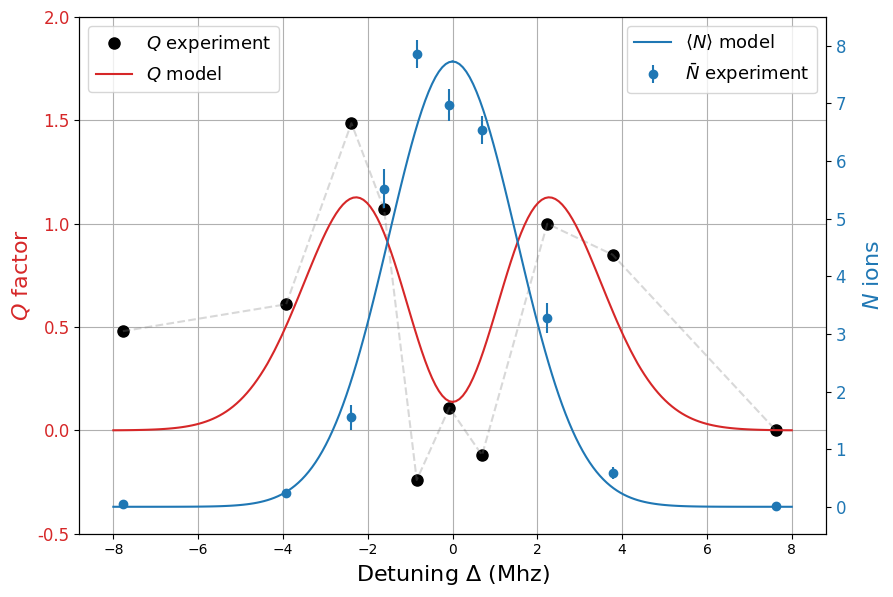

In [46]:

fig, ax1 = plt.subplots(figsize=(9, 6))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

xxs = np.linspace(-5,5, 1000)
yys = gaussian_(xxs, 0, par[1], par[2])
#ax2.plot(xxs, yys, label = "ideal resonance", c="violet")

ax2.errorbar(data_[:,0],  data_[:,2],  data_[:,3], ls = "", marker = "o", label=r"$\bar{N}$ experiment")
ax1.plot(data_[:,0], data_[:,1], ls = "", marker = "o", markersize=8, color="black", label=r"$Q$ experiment")
ax1.plot(data_[:,0], data_[:,1], ls = "--", marker = "", markersize=8, color="grey", alpha=0.3)


############################# simulations

y=gaussian_(f0_vals,0,g,n_max)

color = 'tab:red'
ax1.set_xlabel(r'Detuning $\Delta$ (Mhz)', fontsize=16)
ax1.set_ylabel(r'$Q$ factor', color=color, fontsize=16)
ax1.plot(f0_vals, Q, "-", color=color, label=r"$Q$ model")
ax1.plot(-f0_vals, Q, "-", color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([0,0.75])#max(Q)+0.05])

color = 'tab:blue'
ax2.set_ylabel(r'$N$ ions', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.plot(f0_vals, n_means, "-", color=color, label=r"$\langle {N}\rangle$ model")
ax2.plot(-f0_vals, n_means, "-", color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0,n_max+1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()

#plt.plot(f0_vals, y, c="b", label="ideal lorentian")
#plt.plot(-f0_vals, y, c="b")
ax1.legend(loc=2, fontsize=13)
ax2.legend(loc=1, fontsize=13)

ax1.set_yticks(np.arange(-0.5,2.5,0.5), fontsize=14)
ax1.set_yticklabels(np.arange(-0.5,2.5,0.5), fontsize=12)
ax2.set_yticks(np.arange(-0,9,1), fontsize=14)
ax2.set_yticklabels(np.arange(0,9,1), fontsize=12)

ax2.yaxis.set_label_coords(1.05, 0.5)


plt.savefig('gaussian_jitter__001.png', dpi=300)

plt.show()

index 1 : 0.87 1.3